<a href="https://colab.research.google.com/github/ValentinBhend/Trinary-Tree/blob/main/Trinary_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

In [ ]:
def gen_rand():
    r = random.random()
    t = random.random()
    x = r * np.cos(t*2*np.pi)
    y = r * np.sin(t*2*np.pi)
    return [float(x), float(y)]

def min_distance(p,n,v):
    xn, yn = n
    xp, yp = p
    xq, yq = xn-xp, yn-yp
    xv, yv = v
    f = (xv * xq + yv * yq) / (xv**2 + yv**2)
    x_min = xq - f * xv
    y_min = yq - f * yv
    if f >= 0:
        return np.sqrt(x_min**2 + y_min**2)
    else:
        return np.inf

def apply_to_tree(tree, n, V, D):
    p = tree[0]
    xp, yp = p
    xn, yn = n
    min_dists = [min_distance(p,n,V[i]) for i in range(D)]
    branch = np.argmin(min_dists)
    if len(tree[branch+1]) == 0: # base case
        tree[branch+1] = [n] + [[] for _ in range(D)]
    else:
        tree[branch+1] = apply_to_tree(tree[branch+1], n, V, D)
    return tree

def dist(v,w):
    xv, yv = v
    xw, yw = w
    return np.sqrt((xv-xw)**2 + (yv-yw)**2)

def calc_edges(tree, D):
    if len(tree) == 0:
        return []
    p = tree[0]
    edges = []
    for i in range(D):
        if len(tree[i+1]) == 0:
            pass
        else:
            new_edge = [p, tree[i+1][0], i+1]
            sub_edges = calc_edges(tree[i+1], D)
            edges.append(new_edge)
            edges.extend(sub_edges)
    return edges

def add(v,w):
    return [v[0]+w[0],v[1]+w[1]]

def generate_plot(D, tree, p0, q, V1, d):
    fig, ax = plt.subplots()
    edges = calc_edges(tree, D)
    for edge in edges:
        x1, y1 = edge[0]
        x2, y2 = edge[1]
        c = edge[2]
        color = "b" * (c==1) + "r" * (c==2) + "g" * (c==3)
        if color == "":
            color = "y"
        plt.plot([x1,x2], [y1,y2], color=color)
    ax.scatter(p0[0], p0[1], color="b")
    ax.scatter(q[0], q[1], color="r")
    circ = plt.Circle(q, d, color='k')
    circ.set_facecolor("none")
    ax.add_patch(circ)

    dash_lines = [[p0, add(p0, V1[i])] for i in range(D)]
    for dl in dash_lines:
        x1, y1 = dl[0]
        x2, y2 = dl[1]
        plt.plot([x1,x2], [y1,y2], linestyle='dashed')

    fig.show()

def find_inside(q, tree, d, V, V1, D):
    cost = 0
    if len(tree) == 0:
        return [], cost
    cost += 1
    points = []
    p = tree[0]
    min_dists = [min_distance(p,q,V[i]) for i in range(D)]
    branch = np.argmin(min_dists)
    min_dists_1 = [min_distance(p,q,V1[i]) for i in range(D)]
    branches_to_search = [branch]

    if dist(p,q) <= d:
        points.append(p)
        branches_to_search = [i for i in range(D)]
    else:
        for i, md1 in enumerate(min_dists_1):
            if md1 < d:
                branches_to_search.extend([(i+j+1)%len(V) for j in range(D)])
    for i in range(D):
        if i in branches_to_search:
            new_points, new_cost = find_inside(q, tree[i+1], d, V, V1, D)
            points.extend(new_points)
            cost += new_cost
    return points, cost

def find_in_arr(q, arr, d):
    points = []
    for a in arr:
        if dist(a,q) <= d:
            points.append(a)
    return points

def test_algorithm(D, N, d, show_plot=False):
    V = [[np.cos(i*2*np.pi/D),np.sin(i*2*np.pi/D)] for i in range(D)]
    V1 = [[-V[i][0], -V[i][1]] for i in range(D)]

    p0 = gen_rand()
    tree = [p0] + [[] for _ in range(D)]
    arr = [p0]
    for _ in range(N):
        n = gen_rand()
        arr.append(n)
        tree = apply_to_tree(tree, n, V, D)

    q = random.choice(arr)

    points_arr = find_in_arr(q, arr, d)
    points_tree, cost_tree = find_inside(q, tree, d, V, V1, D)
    assert sorted(points_arr,key=lambda l:l[0]) == sorted(points_tree,key=lambda l:l[0]), "algorithm failed"

    if show_plot:
        generate_plot(D, tree, p0, q, V1, d)

    k = len(points_tree)
    return cost_tree, k

Generate and plot a small tree.

5 1


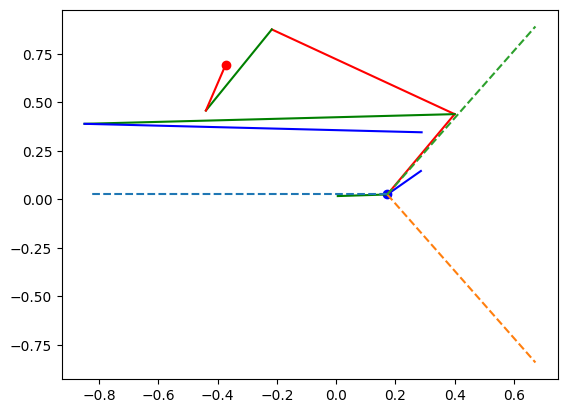

In [ ]:
cost, k = test_algorithm(3, 8, 0, show_plot=True)
print(cost, k)

Test the algorithm with a few different number of points N and distances d.
Takes about 15s to run.

In [ ]:
random.seed(0)
D = 3
measurements = []
N_space = [10**i for i in range(5)]
d_space = [0.5*i for i in range(5)]
for N in N_space:
    for d in d_space:
        cost, k = test_algorithm(D, N, d)
        measurements.append([N, cost, k])

Plot the cost of the calculations above.

[1.14988695]


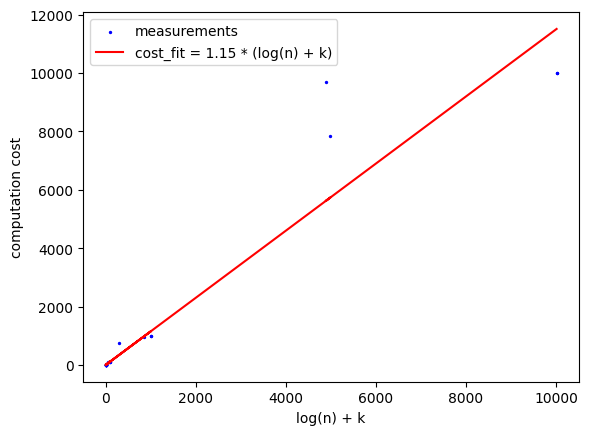

In [ ]:
X = []
Y = []
for m in measurements:
    N, c, k = m
    X.append(np.log(N) + k)
    Y.append(c)

def lin(x, a):
    return a*x

popt, pcov = curve_fit(lin,X,Y,p0=1)
print(popt)
a = popt[0]


plt.scatter(X,Y, s=2, color="b", label="measurements")
Y_fit = [a*x for x in X]
plt.plot(X, Y_fit, color="r", label=f"cost_fit = {round(a,3)} * (log(n) + k)")
plt.xlabel("log(n) + k")
plt.ylabel("computation cost")
plt.legend()
plt.show()